# Explore renthop data


The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site. 



In [92]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap

In [2]:
train = pd.read_json('data/train.json')
train = train.set_index('listing_id')
train['created'] = pd.to_datetime(train['created'])

In [3]:
train.shape

(49352, 14)

In [4]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'longitude', 'manager_id', 'photos', 'price', 'street_address'],
      dtype='object')

In [5]:
# what is submitted?

submission = pd.read_csv('data/sample_submission.csv.zip', compression='zip')

In [6]:
# for each listing_id will be generating probabilities for each of high, medium , low
submission.head(3)

,listing_id,high,medium,low
0,7142618,0.077788,0.227529,0.694683
1,7210040,0.077788,0.227529,0.694683
2,7174566,0.077788,0.227529,0.694683


In [574]:
# sample submission is just the proportions of interest as in the training set
train.interest_level.value_counts(normalize=True)

low       0.694683
medium    0.227529
high      0.077788
Name: interest_level, dtype: float64

# evaluation

multi-class logarithmic loss. 



In [9]:
from sklearn import metrics

In [11]:
predictions = pd.DataFrame({'listing_id': train.index.values, 
              'high': train_proportions['high'],
              'medium': train_proportions['medium'],
              'low': train_proportions['low']})
predictions.head(1)

,high,listing_id,low,medium
0,0.077788,7211212,0.694683,0.227529


In [12]:
predictions = predictions \
                .set_index('listing_id') \
                .assign(actual = train.interest_level)

In [13]:
metrics.log_loss(predictions.actual, predictions.drop('actual', 1).values)

0.78857691143225461

# data exploration

## some distributions

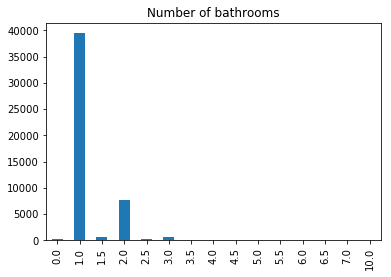

In [14]:
train.bathrooms.value_counts().sort_index().plot.bar()
plt.title('Number of bathrooms')

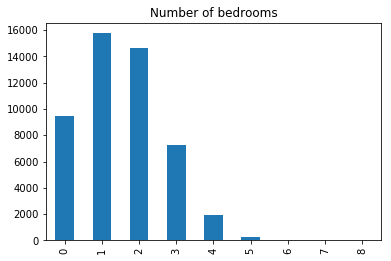

In [15]:
train.bedrooms.value_counts().sort_index().plot.bar()
plt.title('Number of bedrooms')

In [21]:
## is this missing data or....

train.loc[train.bedrooms == 0].shape

(9475, 14)

In [24]:
train.loc[train.bedrooms == 0].interest_level.value_counts()

low       6518
medium    2110
high       847
Name: interest_level, dtype: int64

In [18]:
train.manager_id.nunique()

3481

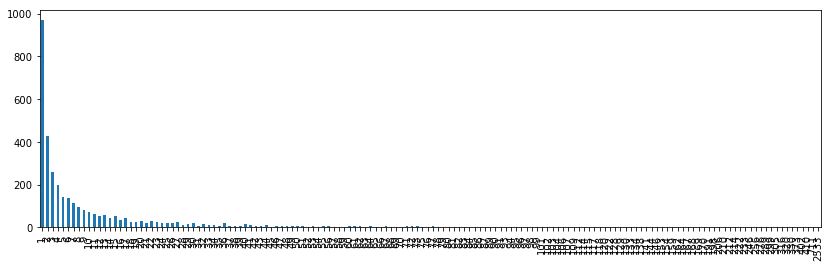

In [27]:
train.manager_id.value_counts().value_counts().sort_index().plot.bar(figsize=(14,4))

In [29]:
## maybe there are some managers that are better at getting higher interest level

listings_per_manager_by_interest_level = (train
.groupby(['manager_id', 'interest_level'])
.size()
.reset_index()
.pipe(pd.pivot_table, index='manager_id', columns='interest_level', values=0)
.fillna(0)
.astype(int)[['low', 'medium', 'high']]
)

In [34]:
## how to visualise this?? clustering??

listings_per_manager_by_interest_level.shape

(3481, 3)

In [45]:
interest_proportions_per_manager = listings_per_manager_by_interest_level.divide(listings_per_manager_by_interest_level.sum(1), axis=0)

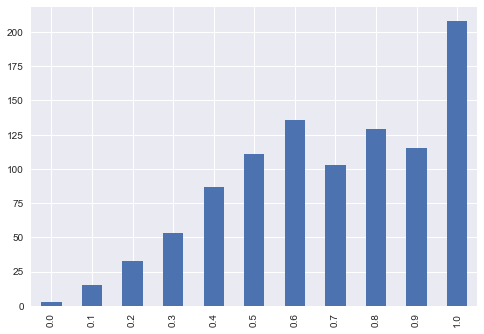

In [93]:
## there seems to be a bunch that only have low interest listings

interest_proportions_per_manager.loc[listings_per_manager_by_interest_level.sum(1) > 10].low.round(1).value_counts().sort_index().plot.bar()

In [371]:
## create feature of being low interest manager_id

In [387]:
low_interest_manager_ids = interest_proportions_per_manager.loc[((listings_per_manager_by_interest_level.sum(1) > 10)
                                     & (interest_proportions_per_manager.low > 0.95))].index.values
low_interest_manager_ids.shape

(207,)

In [393]:
train[train.manager_id.isin(low_interest_manager_ids)].interest_level.value_counts(normalize=True)

low       0.989061
medium    0.008812
high      0.002127
Name: interest_level, dtype: float64

In [404]:
## function to create feature that indicates low interest manager id

train.loc[:,'low_interest_manager_id'] = 0
train.loc[train.manager_id.isin(low_interest_manager_ids), 'low_interest_manager_id'] = 1
train.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,manager_id,photos,price,street_address,description_length,low_interest_manager_id
listing_id,,,,,,,,,,,,,,,,
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,588,0


In [405]:
train.low_interest_manager_id.sum()

6582

/home/dg/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


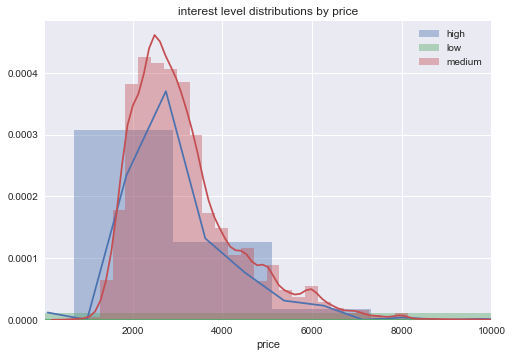

In [113]:

train.groupby('interest_level').apply(lambda x: sns.distplot(x.price, label=x.name))
plt.xlim(50, 10000)
plt.legend()
plt.title('interest level distributions by price')

In [125]:
n_interest_levels = train.interest_level.value_counts()

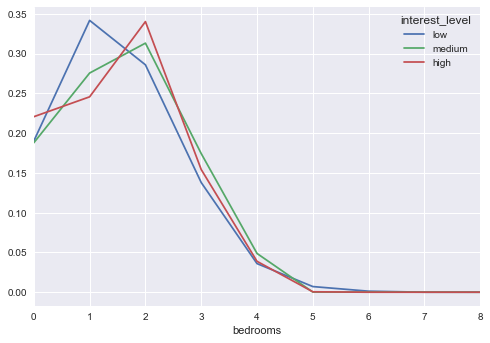

In [139]:
(train
.groupby(['interest_level', 'bedrooms'])
.size()
.reset_index()
.pipe(pd.pivot_table, columns='interest_level', index='bedrooms', values=0)
.fillna(0).astype(int)
[['low', 'medium', 'high']]
.divide(n_interest_levels)
).plot.line()

In [145]:
train['description_length'] = train.description.apply(lambda x: len(x))

/home/dg/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


interest_level
high      Axes(0.125,0.125;0.775x0.755)
low       Axes(0.125,0.125;0.775x0.755)
medium    Axes(0.125,0.125;0.775x0.755)
dtype: object

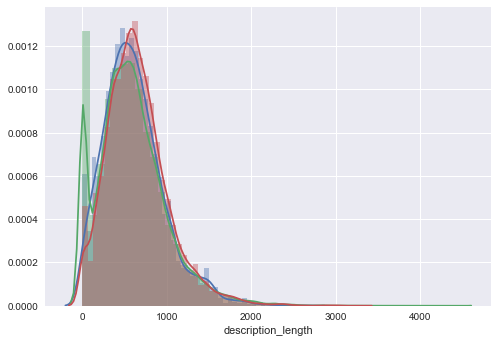

In [151]:
(train
.groupby(['interest_level'])
.apply(lambda x: sns.distplot(x.description_length, label=x.name))
)

In [258]:
high_latitudes = train.loc[((train.latitude != 0) & (train.longitude != 0) & (train.interest_level == 'high'))]
high_level_latitude = high_latitudes.latitude.tolist()
high_level_longitude = high_latitudes.longitude.tolist()


In [259]:
med_latitudes = train.loc[((train.latitude != 0) & (train.longitude != 0) & (train.interest_level == 'medium'))]
med_level_latitude = med_latitudes.latitude.tolist()
med_level_longitude = med_latitudes.longitude.tolist()


In [260]:
low_latitudes = train.loc[((train.latitude != 0) & (train.longitude != 0) & (train.interest_level == 'low'))]
low_level_latitude = low_latitudes.latitude.tolist()
low_level_longitude = low_latitudes.longitude.tolist()


/home/dg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/dg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/dg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/dg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


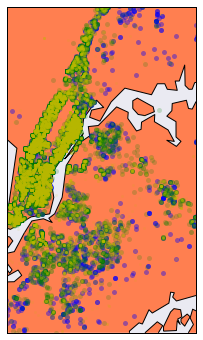

In [271]:
lower = 0.5
upper = 99.5

plt.figure(figsize=(12,6))

my_map = Basemap(projection='merc', 
                 lat_0=np.mean(train.latitude), 
                 lon_0=np.mean(train.longitude),
                 resolution = 'h', 
                 area_thresh = 0.1,
                 llcrnrlon=np.percentile(train.longitude, lower), 
                 llcrnrlat=np.percentile(train.latitude, lower),
                 urcrnrlon=np.percentile(train.longitude, upper), 
                 urcrnrlat=np.percentile(train.latitude, upper))
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='coral')
my_map.drawmapboundary()
 
x,y = my_map(high_level_longitude, high_level_latitude)
my_map.plot(x, y, 'bo', markersize=5, alpha=0.4)

x,y = my_map(med_level_longitude, med_level_latitude)
my_map.plot(x, y, 'go', markersize=5, alpha=0.2)

x,y = my_map(low_level_longitude, low_level_latitude)
my_map.plot(x, y, 'yo', markersize=3, alpha=0.1)

plt.show()

## Created

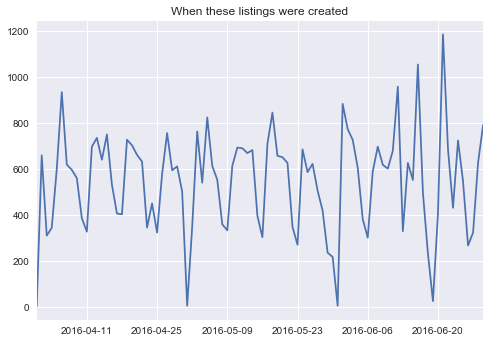

In [572]:
train.created.dt.date.value_counts().sort_index().plot.line()
plt.title('When these listings were created')
plt.show()

/home/dg/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


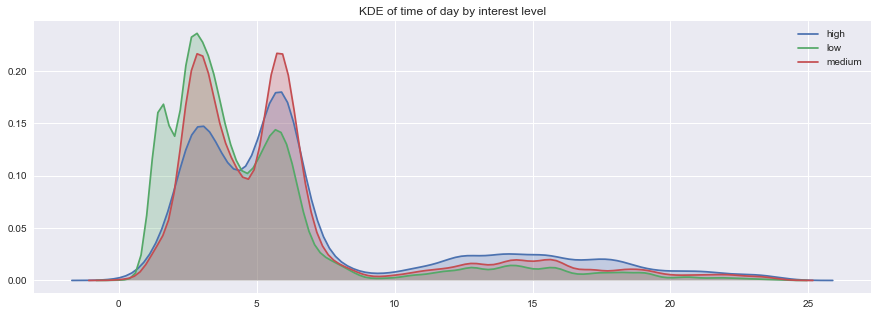

In [573]:
plt.figure(figsize=(15,5))
(train
.groupby('interest_level')
.apply(lambda df: sns.kdeplot((df.created.dt.hour 
                               + (df.created.dt.minute / 60)
                               + (df.created.dt.second / 360))
                              , shade=True, label=df.name))
)
plt.title('KDE of time of day by interest level')
plt.legend()
plt.show()

## Building Id

In [475]:
train.shape

(49352, 16)

In [477]:
train.building_id.nunique()

7585

In [487]:
## this seems to be higher than the typical distribution?
train[train.building_id == '0'].interest_level.value_counts(normalize=True)

low       0.915762
medium    0.060705
high      0.023534
Name: interest_level, dtype: float64

In [499]:
by_building_id = (train
.loc[train.building_id != '0']
.groupby(['building_id', 'interest_level'])
.size()
.reset_index()
.pipe(pd.pivot_table, columns='interest_level', index='building_id', values=0)
.fillna(0).astype(int)
[['low', 'medium', 'high']]
)

In [504]:
by_building_proportions = by_building_id.divide(by_building_id.sum(1), axis=0)

In [510]:
low_interest_buildings = (by_building_proportions.
                            loc[((by_building_id.sum(1) > 10) & 
                                 (by_building_proportions.low > 0.95))])
low_interest_buildings.head(1)

interest_level,low,medium,high
building_id,,,
009f494b0636f32b96b41926ec7c4bf2,1.0,0.0,0.0


In [515]:
train.loc[train.building_id.isin(low_interest_buildings.index.values)].interest_level.value_counts()

low       1372
medium      23
high         1
Name: interest_level, dtype: int64

In [577]:
train.loc[:,'low_interest_building_id'] = 0
train.loc[train.building_id.isin(low_interest_buildings.index.values), 'low_interest_building_id'] = 1
train.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,manager_id,photos,price,street_address,description_length,low_interest_manager_id,low_interest_building_id,no_building_id
listing_id,,,,,,,,,,,,,,,,,,
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,588,0,0,0


In [535]:
train.loc[:,'no_building_id'] = 0
train.loc[train.building_id == '0', 'no_building_id'] = 1
train.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,manager_id,photos,price,street_address,description_length,low_interest_manager_id,low_interest_building_id,no_building_id
listing_id,,,,,,,,,,,,,,,,,,
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,588,0,0,0


In [576]:
train.low_interest_building_id.sum()

0

In [580]:
train.groupby(['low_interest_manager_id', 'low_interest_building_id', 'no_building_id']).size()

low_interest_manager_id  low_interest_building_id  no_building_id
0                        0                         0                 36646
                                                   1                  5002
                         1                         0                  1122
1                        0                         0                  3024
                                                   1                  3284
                         1                         0                   274
dtype: int64

## some basic predictions

In [581]:
import sklearn as sk

setup test and train

In [592]:
features = ['bathrooms', 'bedrooms', 'price', 
            'description_length', 'latitude', 
            'longitude', 'low_interest_manager_id',
           'low_interest_building_id', 'no_building_id']
X = train[features]
y = train['interest_level']

In [593]:
sss = sk.model_selection.StratifiedShuffleSplit(n_splits = 2, test_size=0.2, random_state=0)
sss.get_n_splits(X=X, y=y)

2

In [594]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [17984 36593  7219 ..., 17629 40833 20954] TEST: [37887 39631 10074 ..., 20903 26267 16106]
TRAIN: [47718 17388 47139 ..., 12099 27110 39561] TEST: [  501 33857  9196 ...,  7458 31635 42554]


In [595]:
X_train.head(1)

,bathrooms,bedrooms,price,description_length,latitude,longitude,low_interest_manager_id,low_interest_building_id,no_building_id
listing_id,,,,,,,,,
6891817,1.0,1,3231,2377,40.678,-73.9909,0,0,0


In [596]:
print(y_train.head(1))
print(y_train.shape)

listing_id
6891817    low
Name: interest_level, dtype: object
(39481,)


fit model

In [597]:
# default model to fit is one vs rest 
# tried multinomial and it was worse...
logreg = linear_model.LogisticRegression()

In [598]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

evaluate

In [599]:
y_pred = logreg.predict_proba(X_test)

In [600]:
y_pred_labels = logreg.predict(X_test)

In [601]:
sk.metrics.log_loss(y_true=y_test, y_pred=y_pred)

0.67857412308473286